# graph layout
with Formula 1 data from https://ergast.com/mrd/db/

In [1]:
%autosave 0

from itertools import permutations
from tools import *

f1 = ErgastZIP(ERGAST_ZIP)
plot = Plot()

Autosave disabled


In [2]:
%%time
mates = (
    f1.results['id_driver id_race id_team'.split()]
    .join(f1.races['season race'.split()], on='id_race')
    .join(f1.drivers['driver'], on='id_driver')
    .join(f1.teams['team'], on='id_team')
    .groupby('season race team'.split())['driver']
    .apply(lambda s: list(permutations(s, 2)))
    .explode()
)
mates = DataFrame(mates.tolist(),index = mates.index)
mates.columns = 'source target'.split()
mates

CPU times: user 1.56 s, sys: 0 ns, total: 1.56 s
Wall time: 1.57 s


source            target
season race                     team                                         
1950   Belgian Grand Prix       Alfa Romeo      Juan Fangio     Luigi Fagioli
                                Alfa Romeo      Juan Fangio       Nino Farina
                                Alfa Romeo    Luigi Fagioli       Juan Fangio
                                Alfa Romeo    Luigi Fagioli       Nino Farina
                                Alfa Romeo      Nino Farina       Juan Fangio
...                                                     ...               ...
2019   United States Grand Prix Renault     Nico Hülkenberg  Daniel Ricciardo
                                Toro Rosso     Daniil Kvyat      Pierre Gasly
                                Toro Rosso     Pierre Gasly      Daniil Kvyat
                                Williams     George Russell     Robert Kubica
                                Williams      Robert Kubica    George Russell

[40420 rows x 2 columns]

In [3]:
graph = Graph(mates)
graph

Graph with 9988 links
              source                 target  weight
0       Adolf Brudes            Fritz Riess       1
1       Adolf Brudes             Hans Klenk       1
2       Adolf Brudes           Josef Peters       1
3       Adolf Brudes           Paul Pietsch       1
4       Adolf Brudes          Theo Helfrich       1
...              ...                    ...     ...
9983  Óscar González             Jean Behra       1
9984  Óscar González  José Froilán González       1
9985  Óscar González           Luigi Piotti       1
9986  Óscar González          Mike Hawthorn       1
9987  Óscar González          Stirling Moss       1

[9988 rows x 3 columns]

## brundlegree

790 drivers within 7 degrees of Martin Brundle
Save /context/data/plots/brundlegree.png


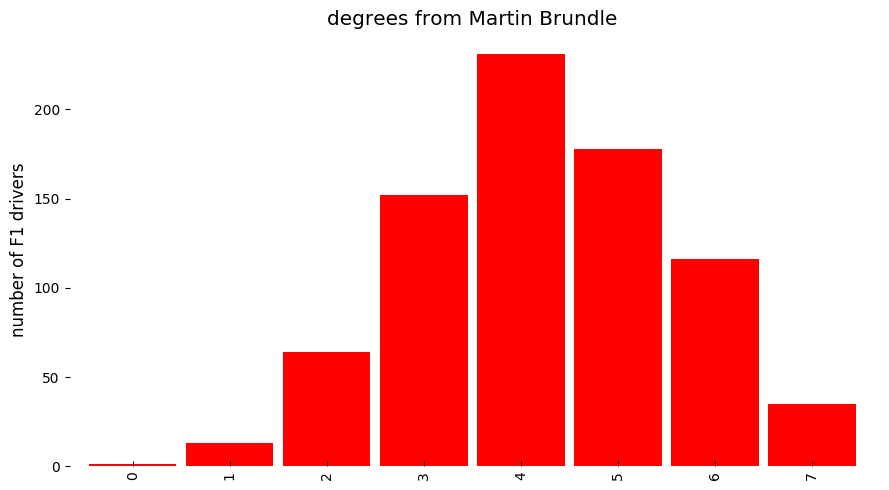

In [4]:
def bacondeg(graph, core):
    nodes = graph.nodes
    source = graph.links['source']
    target = graph.links['target']

    frontier = {core}
    bacon = Series(-1, index=nodes)
    for i in range(100):
        bacon[frontier] = i
        marked = set(nodes[bacon.gt(-1)])
        frontier = set(target[source.isin(frontier)]) - marked
        if not frontier:
            return bacon

def showbacon(graph, core, **kwargs):
    kwargs.setdefault('color', 'r')
    kwargs.setdefault('legend', False)
    kwargs.setdefault('title', f"degrees from {core}")
    kwargs.setdefault('ylabel', 'number of F1 drivers')
    
    data = bacondeg(graph, core)
    data = data[data >= 0].value_counts().sort_index()
    maxdeg = data.index.max()
    print(f"{data.sum()} drivers within {maxdeg} degrees of {core}")
    
    return plot.bar(data, **kwargs)
     
axes = showbacon(graph, 'Martin Brundle')
savepng(axes, 'brundlegree')

## doppelgänger

In [5]:
data = (
    graph.links
    .sort_values('weight', ascending=False)
    .iloc[:20:2, :].reset_index(drop=True)
)
data.columns = 'driver driver races'.split()
data.index += 1
savehtml(data, 'doppels')
data

Save /context/data/tables/doppels.html


,driver,driver,races
1,Rubens Barrichello,Michael Schumacher,104
2,David Coulthard,Mika Häkkinen,99
3,Mark Webber,Sebastian Vettel,94
4,Kimi Räikkönen,Sebastian Vettel,81
5,Lewis Hamilton,Nico Rosberg,78
6,Felipe Massa,Fernando Alonso,77
7,Jean Alesi,Gerhard Berger,77
8,Jenson Button,Rubens Barrichello,70
9,Elio de Angelis,Nigel Mansell,62
10,Maurício Gugelmin,Ivan Capelli,62


## voyagers

In [6]:
data = bacondeg(graph, 'Martin Brundle')
data = data.loc[data.le(0)]
data = (
    f1.drivers
    .loc[lambda df: df['driver'].isin(data.index)]
    ['driver nation birthday'.split()]
    .sort_values('birthday')
    .reset_index(drop=True)
)
data.index += 1
savehtml(data, 'voyagers')
data

Save /context/data/tables/voyagers.html


,driver,nation,birthday
1,Bill Cantrell,American,1908-01-31
2,Joe Kelly,Irish,1913-03-13
3,Bayliss Levrett,American,1914-02-14
4,Paul Emery,British,1916-11-12
5,Geoff Crossley,British,1921-05-11
6,Peter Broeker,Canadian,1926-05-15
7,Bernie Ecclestone,British,1930-10-28
8,Bruce Kessler,American,1936-03-23
9,Ernie de Vos,Dutch,1941-07-01
10,Martin Brundle,British,1959-06-01


## use the force

In [7]:
%%time
frame = graph.frame(90)
frame.head()

CPU times: user 3.99 s, sys: 0 ns, total: 3.99 s
Wall time: 4 s


,x,y
Adolf Brudes,0.915676,-0.325991
Adolfo Cruz,-0.452198,-0.638996
Adrian Sutil,0.095705,0.692199
Adrián Campos,-0.667467,-0.205747
Aguri Suzuki,-0.490475,0.019201


In [8]:
frame['degree'] = bacondeg(graph, 'Martin Brundle')
frame['nraces'] = graph.links.groupby('source')['weight'].sum()
frame['url'] = f1.drivers.set_index('driver')['url']
frame = (
    frame.rename_axis('driver')
    .loc[frame['degree'].ge(0)]
    .sort_values('nraces degree'.split(), ascending=False)
)
frame.to_csv(TABLEDIR / 'brundle.csv')
frame.tail()

,x,y,degree,nraces,url
driver,,,,,
Stephen South,-0.844306,-0.334387,4,1,http://en.wikipedia.org/wiki/Stephen_South
Vincenzo Sospiri,0.240757,-0.819545,4,1,http://en.wikipedia.org/wiki/Vincenzo_Sospiri
Warwick Brown,-0.249295,0.913340,4,1,http://en.wikipedia.org/wiki/Warwick_Brown
Jo Vonlanthen,-0.910068,-0.302563,3,1,http://en.wikipedia.org/wiki/Jo_Vonlanthen
Marco Apicella,0.861821,-0.230149,2,1,http://en.wikipedia.org/wiki/Marco_Apicella


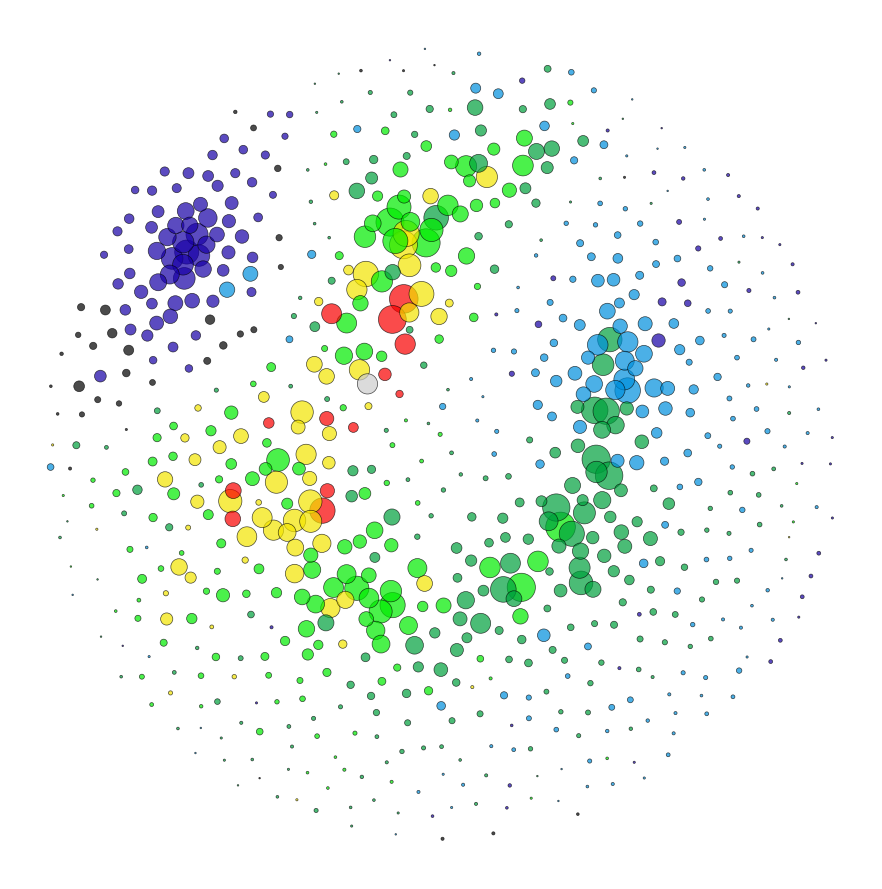

In [9]:
def show(frame, core, **kwargs):
    kwargs.setdefault('cmap', 'nipy_spectral_r')
    kwargs.setdefault('edgecolor', 'black')
    kwargs.setdefault('figsize', (9, 9))
    kwargs.setdefault('grid', False)
    kwargs.setdefault('xticks', [])
    kwargs.setdefault('yticks', []) 

    data = frame[frame['degree'].ge(0)].copy()
    data['nraces'] *= 64 / data['nraces'].mean()
    axes = plot.scatter(data, **kwargs)
    axes.set_aspect('equal', 'box')

    return axes
    
axes = show(frame, 'Martin Brundle')
#savepng(axes, 'brundle')